# Исследование надежности заемщиков

## Вступление

Всем привет! Меня зовут Васюхин Артём и это мой проект по исследованию надёжности заёмщиков для одного из банков. Входные данные от банка — общие сведения о клиентах с целевым признаком числа задолженностей.


**Цель проекта:** проанализировать поведение различных клиентов банка и проверить следующие гипотезы:
1. количество детей клиента не влияет на погашение кредита в срок;
2. семейное положение не влияет на погашение кредита в срок.

Результаты исследования будут использованы для построения скоринговой ML-модели.

### Описание данных ###

* <code>children</code> — количество детей в семье
* <code>days_employed</code> — общий трудовой стаж в днях
* <code>dob_years</code> — возраст клиента в годах
* <code>education</code> — уровень образования клиента
* <code>education_id</code> — идентификатор уровня образования
* <code>family_status</code> — семейное положение
* <code>family_status_id</code> — идентификатор семейного положения
* <code>gender</code> — пол клиента
* <code>income_type</code> — тип занятости
* <code>debt</code> — имел ли задолженность по возврату кредитов
* <code>total_income</code> — ежемесячный доход
* <code>purpose</code> — цель получения кредита

## Импорт библиотек и данных

In [1]:
# классические библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats as st

C:\Users\Home\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# обработчики
import random
import os
import re
import phik

In [3]:
# sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# tqdm
from tqdm import tqdm

# catboost
from catboost import CatBoostClassifier, Pool

In [4]:
pth_1 = 'client_behavior.csv'
pth_2 = 'datasets/client_behavior.csv'

if os.path.exists(pth_1):
    df = pd.read_csv(pth_1)
elif os.path.exists(pth_2):
    df = pd.read_csv(pth_2)
else:
    print('Check the route')

In [5]:
display(df.head())
print('\n', '='*120, '\n')
display(df.info())
print('\n', '='*120, '\n')
display(df.isna().sum())

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


None

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

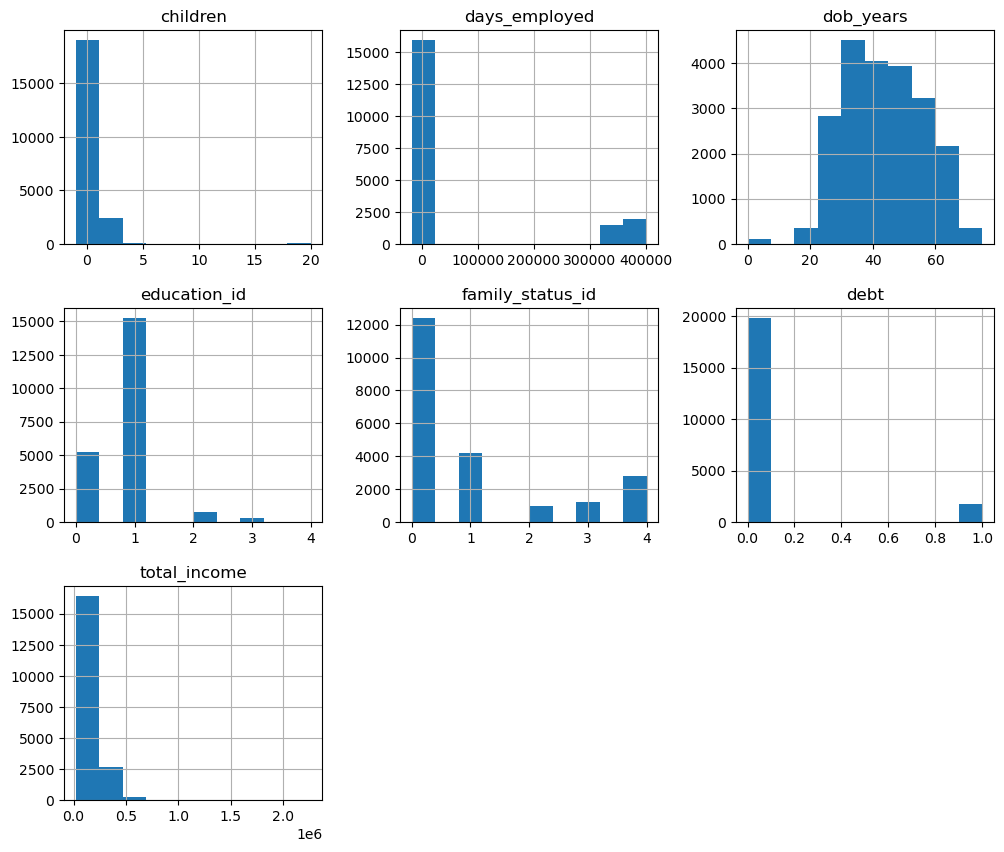

In [6]:
df.hist(figsize=(12, 10));

### Вывод по первичному анализу данных ##

Импортировав данные и выведя первичную информацию, мы можем заметить дисбаланс численного признака в целевой группе "Дети" и преобладание нулевой категории в группе "Семейное положение".

Также имеются дисбалансы в колонках: "Трудовой стаж", "Образование", "Задолженность" и "Ежемесячный доход"; Смежные ропуски в "Трудовом стаже" и "Ежемесячном доходе" объясняются выдачей займы людям, имеющим неофициальное устройство.

Проведем EDA.

## EDA ##

### Функции предобработки ###

In [7]:
# информация о колонке
def col_info(data, col):
    display(data[col].info)
    print('='*120)
    print('Пропущенных значений:', data[col].isna().sum())
    print('='*120)
    display(data[col].value_counts())
    
# ящик с усами
def boxplot_col(data, col):
    data.boxplot(col, figsize=(8, 3), fontsize=12, vert=False)

### children ###

In [8]:
df.children.value_counts()

children
 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: count, dtype: int64

Согласно статистике за 2021 год, число семей с тремя и более детьми в России не превышает 12%. Учитывая, что данный признак является целевым для одной из гипотез, мы проверим на задолженность клиентов, где детей четыре и более, попутно избавившись от очевидных выбросов значений 20 и -1 соответственно.

In [9]:
df = df.query('children >= 0 & children < 10')

In [10]:
df.groupby('children')['debt'].agg('sum')

children
0    1063
1     444
2     194
3      27
4       4
5       0
Name: debt, dtype: int64

In [11]:
df.children = df.children.replace([i for i in df.children if i > 3])
df.children.value_counts()

C:\Users\Home\AppData\Local\Temp\ipykernel_19060\4279817435.py:1: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  df.children = df.children.replace([i for i in df.children if i > 3])


children
0    14180
1     4831
2     2059
3      332
Name: count, dtype: int64

### days_employed ###

In [12]:
col_info(df, 'days_employed')

<bound method Series.info of 0         -8437.673028
1         -4024.803754
2         -5623.422610
3         -4124.747207
4        340266.072047
             ...      
21520     -4529.316663
21521    343937.404131
21522     -2113.346888
21523     -3112.481705
21524     -1984.507589
Name: days_employed, Length: 21402, dtype: float64>

Пропущенных значений: 2162


days_employed
-8437.673028      1
-3963.590317      1
 356425.151366    1
-3112.788664      1
-5135.928528      1
                 ..
 353207.809226    1
-1083.159959      1
 390769.069031    1
 341277.435955    1
-1984.507589      1
Name: count, Length: 19240, dtype: int64

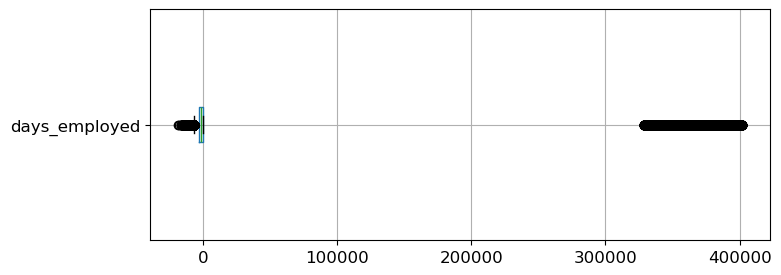

In [13]:
boxplot_col(df, 'days_employed')

In [14]:
# отобразим явные выбросы и посчитаем как много их
df.query('days_employed < 0 | days_employed > 15000')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


Количество очевидно некорректных значений может быть результатом как некорректной записи данных, так и ошибки в расчете дней от указанного стажа в годах.

Проверим догадку о некорректности внесения данных на отрицательных значениях. Предполагается, что минус в записи - это тире. Пересчитаем в годы:

Число записей с отрицательным стажем: 15809


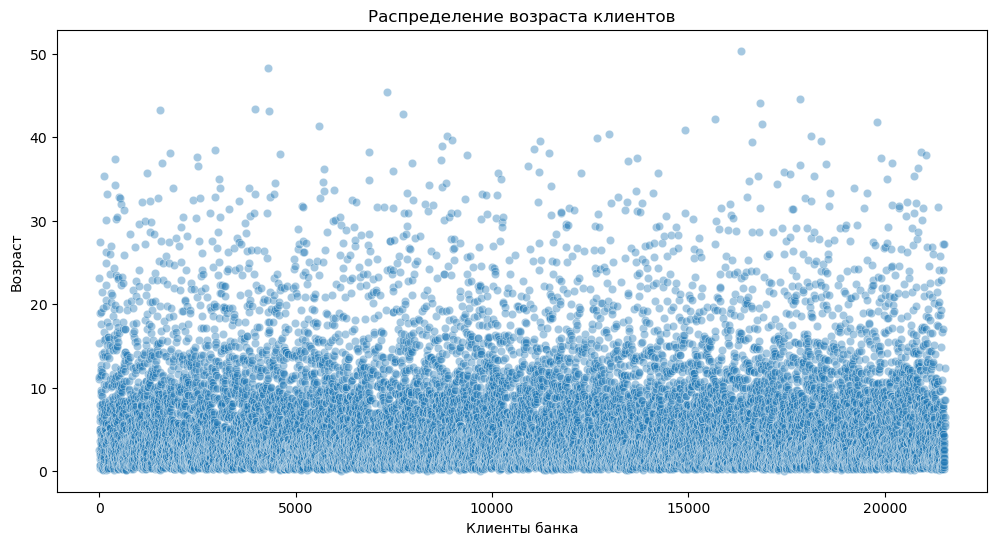

In [15]:
print('Число записей с отрицательным стажем:', (df.loc[df['days_employed'] < 0, 'days_employed'].count()))
print('='*120)
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(data=abs(df.loc[df['days_employed'] < 0, 'days_employed']) / 365, 
                alpha=0.4)
ax.set(xlabel='Клиенты банка', ylabel='Возраст', title='Распределение возраста клиентов');

In [16]:
df.loc[df['days_employed'] < 0, 'days_employed'] = abs(df['days_employed']) / 365
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,23.116912,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,11.026860,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,15.406637,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,11.300677,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,2.537495,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,7.888225,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,0.418574,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,18.985932,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,5.996593,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [17]:
df.query('days_employed > 35 & days_employed < 100')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
111,0,35.426142,61,среднее,1,Не женат / не замужем,4,F,компаньон,0,173896.618274,недвижимость
402,0,37.436159,57,среднее,1,Не женат / не замужем,4,F,сотрудник,0,260593.870890,строительство жилой недвижимости
1225,0,35.686097,57,среднее,1,женат / замужем,0,F,компаньон,0,233376.053639,заняться высшим образованием
1539,0,43.248435,59,высшее,0,Не женат / не замужем,4,F,сотрудник,0,119563.851852,операции с коммерческой недвижимостью
1605,0,36.901048,53,среднее,1,женат / замужем,0,F,госслужащий,0,279650.871320,автомобиль
1798,0,38.118948,62,высшее,0,женат / замужем,0,F,госслужащий,0,169486.507132,приобретение автомобиля
2492,0,37.600613,50,высшее,0,женат / замужем,0,F,сотрудник,0,88152.289893,строительство жилой недвижимости
2524,0,36.556194,63,высшее,0,гражданский брак,1,F,госслужащий,0,131776.880996,свой автомобиль
2938,0,38.496446,65,СРЕДНЕЕ,1,женат / замужем,0,F,госслужащий,0,258879.580616,покупка жилья для семьи
3041,0,35.028884,54,среднее,1,женат / замужем,0,F,компаньон,0,304900.643913,покупка жилья для семьи


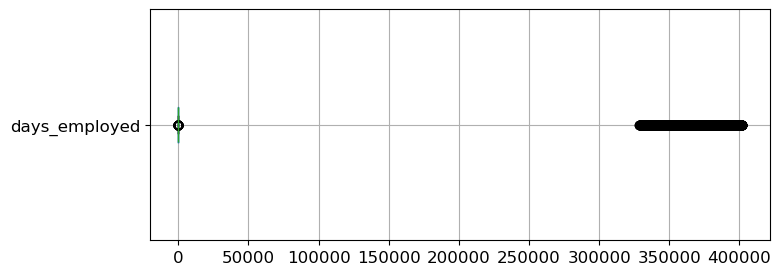

In [18]:
boxplot_col(df, 'days_employed')

На графике видно, что остались только огромные выбросы. Выведем эти строки и сравним примерный стаж с возрастом заёмщика. В случае, если стаж (n) не будет совпадать в разумных рамках с возрастом (n - 18), то можно будет эти строки удалить.

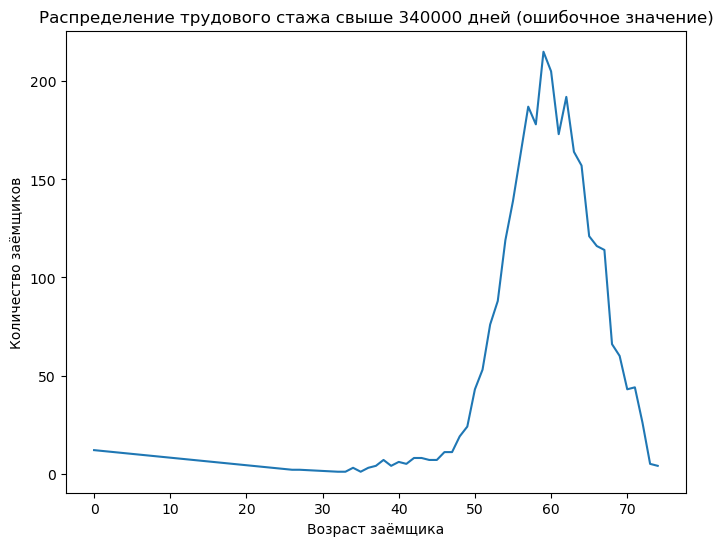

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(df.query('days_employed > 340000').groupby('dob_years')['days_employed'].agg('count'))
ax.set(title='Распределение трудового стажа свыше 340000 дней (ошибочное значение)',
       xlabel='Возраст заёмщика',
       ylabel='Количество заёмщиков');

Исходя из полученных сведений мы видим, что есть как очевидные ошибки при заполнении сведений (0 лет у 12 заёмщиков например), так и отрицательную скошенность. Отсюда мы можем сделать вывод, что для возраста от 50 до 70 лет значения имеют нормальное распределение и являются корректными. Следовательно, можно попробовать уменьшить значения и привести их к годам.

In [20]:
df.loc[df['days_employed'] > 15000, 'days_employed'] = (df['days_employed'] / 1000) / 365

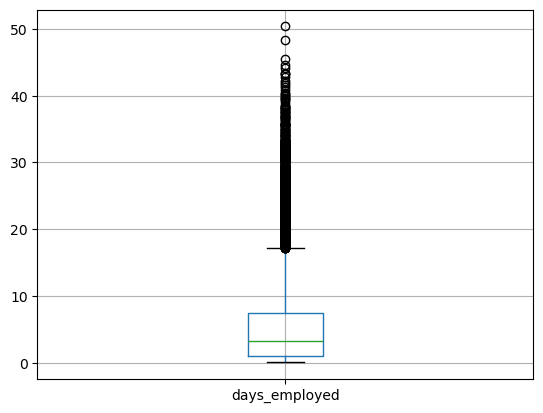

In [21]:
df.boxplot('days_employed');

Теперь мы отчетливо видим как положительную скошенность, так и выбрсы, которые можем удалить, ограничив выборку до 20 лет.

In [22]:
df = df.query('days_employed <= 20')

In [23]:
# переименуем колонку в годы, чтобы не было путаницы
df = df.rename(columns={'days_employed': 'years_employed'})
df['years_employed'] = df['years_employed'].astype(int)

### dob_years ###

In [24]:
col_info(df, 'dob_years')

<bound method Series.info of 1        36
2        33
3        32
4        53
5        27
         ..
21520    43
21521    67
21522    38
21523    38
21524    40
Name: dob_years, Length: 18488, dtype: int64>

Пропущенных значений: 0


dob_years
35    551
34    528
33    526
38    526
41    525
40    522
39    504
29    493
31    491
42    491
36    483
30    478
37    475
32    469
44    456
48    456
27    454
28    444
43    432
50    417
45    415
49    407
56    403
54    396
52    392
46    389
47    387
58    384
59    383
53    377
57    376
26    371
51    360
55    359
25    334
60    323
62    307
61    299
24    242
63    228
64    218
23    216
65    168
22    166
66    158
67    149
21     92
68     89
0      87
69     77
70     61
71     52
20     46
72     29
19     13
73      7
74      6
75      1
Name: count, dtype: int64

In [25]:
df.query('dob_years < 18')

,children,years_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
99,0,0,0,Среднее,1,женат / замужем,0,F,пенсионер,0,71291.522491,автомобиль
149,0,7,0,среднее,1,в разводе,3,F,сотрудник,0,70176.435951,операции с жильем
270,3,5,0,среднее,1,женат / замужем,0,F,сотрудник,0,102166.458894,ремонт жилью
578,0,1,0,среднее,1,женат / замужем,0,F,пенсионер,0,97620.687042,строительство собственной недвижимости
1040,0,3,0,высшее,0,в разводе,3,F,компаньон,0,303994.134987,свой автомобиль
...,...,...,...,...,...,...,...,...,...,...,...,...
19371,1,6,0,высшее,0,женат / замужем,0,F,компаньон,0,77936.218285,автомобиль
20462,0,0,0,среднее,1,женат / замужем,0,F,пенсионер,0,259193.920299,покупка своего жилья
20577,0,0,0,среднее,1,Не женат / не замужем,4,F,пенсионер,0,129788.762899,недвижимость
21179,2,0,0,высшее,0,женат / замужем,0,M,компаньон,0,240702.007382,строительство жилой недвижимости


In [26]:
# удаляем тех, кому меньше 18
df = df.query('dob_years >= 18')

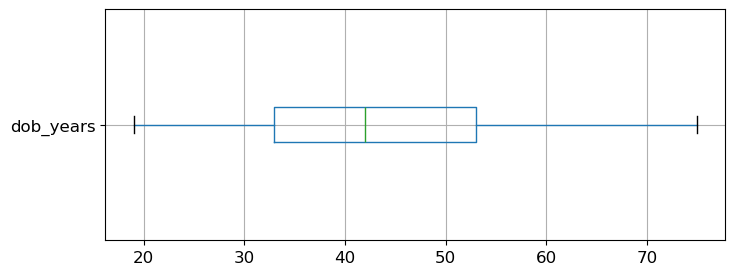

In [27]:
boxplot_col(df, 'dob_years');

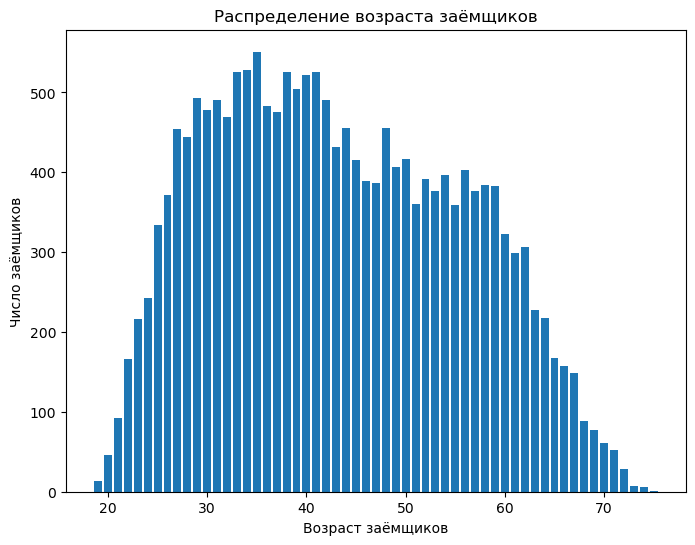

In [28]:
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(df['dob_years'].value_counts().index, 
        height=df['dob_years'].value_counts().values)

ax.set(title = 'Распределение возраста заёмщиков',
        xlabel = 'Возраст заёмщиков',
        ylabel = 'Число заёмщиков')
plt.show;

### education / edu_id ###

In [29]:
col_info(df, 'education')

<bound method Series.info of 1        среднее
2        Среднее
3        среднее
4        среднее
5         высшее
          ...   
21520    среднее
21521    среднее
21522    среднее
21523    среднее
21524    среднее
Name: education, Length: 18401, dtype: object>

Пропущенных значений: 0


education
среднее                11726
высшее                  4019
СРЕДНЕЕ                  652
Среднее                  603
неоконченное высшее      602
ВЫСШЕЕ                   240
Высшее                   233
начальное                228
Неоконченное высшее       40
НЕОКОНЧЕННОЕ ВЫСШЕЕ       22
НАЧАЛЬНОЕ                 16
Начальное                 14
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: count, dtype: int64

Приведем все виды к нижнему регистру для избавления от дублей

In [30]:
df['education'] = df['education'].str.lower()
df['education'].value_counts()

education
среднее                12981
высшее                  4492
неоконченное высшее      664
начальное                258
ученая степень             6
Name: count, dtype: int64

Так как у нас нет точной справки банка о видах учитываемого образования, будем считать полученный результат корректным. Проверим наше предположение, сравнив число видов с их ID

In [31]:
df['education_id'].value_counts()

education_id
1    12981
0     4492
2      664
3      258
4        6
Name: count, dtype: int64

Наш вывод **корректен**.

### family_status / fam_stat_id ###

In [32]:
col_info(df, 'family_status')

<bound method Series.info of 1         женат / замужем
2         женат / замужем
3         женат / замужем
4        гражданский брак
5        гражданский брак
               ...       
21520    гражданский брак
21521     женат / замужем
21522    гражданский брак
21523     женат / замужем
21524     женат / замужем
Name: family_status, Length: 18401, dtype: object>

Пропущенных значений: 0


family_status
женат / замужем          10568
гражданский брак          3556
Не женат / не замужем     2431
в разводе                 1024
вдовец / вдова             822
Name: count, dtype: int64

In [33]:
df['family_status'] = df['family_status'].str.lower() # приведем категории к нижнему регистру

In [34]:
df['family_status'].value_counts()

family_status
женат / замужем          10568
гражданский брак          3556
не женат / не замужем     2431
в разводе                 1024
вдовец / вдова             822
Name: count, dtype: int64

Аналогично с образованием, сравним распределение с ID

In [35]:
col_info(df, 'family_status_id')

<bound method Series.info of 1        0
2        0
3        0
4        1
5        1
        ..
21520    1
21521    0
21522    1
21523    0
21524    0
Name: family_status_id, Length: 18401, dtype: int64>

Пропущенных значений: 0


family_status_id
0    10568
1     3556
4     2431
3     1024
2      822
Name: count, dtype: int64

### gender ###

In [36]:
col_info(df, 'gender')

<bound method Series.info of 1        F
2        M
3        M
4        F
5        M
        ..
21520    F
21521    F
21522    M
21523    M
21524    F
Name: gender, Length: 18401, dtype: object>

Пропущенных значений: 0


gender
F      12037
M       6363
XNA        1
Name: count, dtype: int64

In [37]:
df.query('gender == "XNA"')

,children,years_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,6,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.157261,покупка недвижимости


In [38]:
# удалим неопр. гендер
df = df.query('gender != "XNA"')
df['gender'].value_counts()

gender
F    12037
M     6363
Name: count, dtype: int64

### income_type ###

In [39]:
col_info(df, 'income_type')

<bound method Series.info of 1        сотрудник
2        сотрудник
3        сотрудник
4        пенсионер
5        компаньон
           ...    
21520    компаньон
21521    пенсионер
21522    сотрудник
21523    сотрудник
21524    сотрудник
Name: income_type, Length: 18400, dtype: object>

Пропущенных значений: 0


income_type
сотрудник          9430
компаньон          4390
пенсионер          3412
госслужащий        1163
безработный           2
студент               1
предприниматель       1
в декрете             1
Name: count, dtype: int64

In [40]:
df.query('income_type == ["безработный", "в декрете", "студент", "предприниматель"]')

,children,years_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
3133,1,0,31,среднее,1,женат / замужем,0,M,безработный,1,59956.991984,покупка жилья для сдачи
9410,0,1,22,высшее,0,не женат / не замужем,4,M,студент,0,98201.625314,строительство собственной недвижимости
14798,0,1,45,высшее,0,гражданский брак,1,F,безработный,0,202722.511368,ремонт жилью
18697,0,1,27,высшее,0,гражданский брак,1,F,предприниматель,0,499163.144947,на проведение свадьбы
20845,2,9,39,среднее,1,женат / замужем,0,F,в декрете,1,53829.130729,автомобиль


Важным отличием здесь является уровень дохода и соотношение с просрочками: лица с низким доходом относительно других заёмщиков из данных категорий, однако мы должны удалить категорию "безработный", "студент" и "в декрете", так как эти люди не имеют прямого дохода и, соответственно, это риск для банка.

Предприниматель - это юр.лицо, которые так же должны рассматриваться отдельно.

In [41]:
df = df.query('income_type != ["безработный", "в декрете", "студент", "предприниматель"]')

In [42]:
col_info(df, 'income_type')

<bound method Series.info of 1        сотрудник
2        сотрудник
3        сотрудник
4        пенсионер
5        компаньон
           ...    
21520    компаньон
21521    пенсионер
21522    сотрудник
21523    сотрудник
21524    сотрудник
Name: income_type, Length: 18395, dtype: object>

Пропущенных значений: 0


income_type
сотрудник      9430
компаньон      4390
пенсионер      3412
госслужащий    1163
Name: count, dtype: int64

### total_income ###

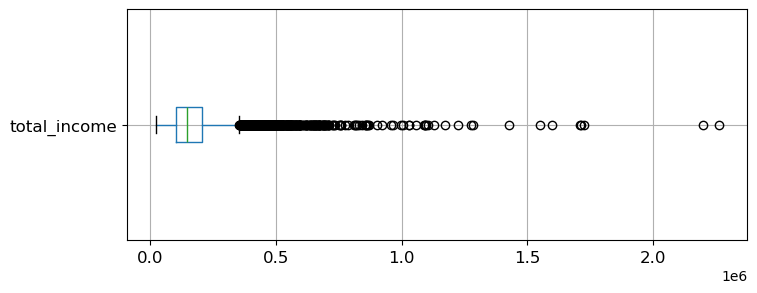

In [43]:
boxplot_col(df, 'total_income')

In [44]:
df.query('total_income > 500000')

,children,years_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
39,0,1,31,высшее,0,гражданский брак,1,F,компаньон,0,754240.797248,заняться образованием
68,2,5,46,высшее,0,женат / замужем,0,M,компаньон,0,592071.464571,операции с коммерческой недвижимостью
365,2,3,36,высшее,0,женат / замужем,0,M,компаньон,0,553624.230462,покупка жилой недвижимости
379,0,19,50,среднее,1,женат / замужем,0,F,сотрудник,1,506773.985753,жилье
685,0,5,52,среднее,1,в разводе,3,F,сотрудник,0,536888.901920,высшее образование
...,...,...,...,...,...,...,...,...,...,...,...,...
21224,0,7,39,неоконченное высшее,2,в разводе,3,F,компаньон,0,574891.367390,покупка жилой недвижимости
21259,0,15,48,среднее,1,женат / замужем,0,M,компаньон,0,575689.161830,получение дополнительного образования
21295,0,0,51,высшее,0,не женат / не замужем,4,F,сотрудник,0,816023.123518,приобретение автомобиля
21392,2,4,35,высшее,0,женат / замужем,0,M,компаньон,0,636515.293426,строительство собственной недвижимости


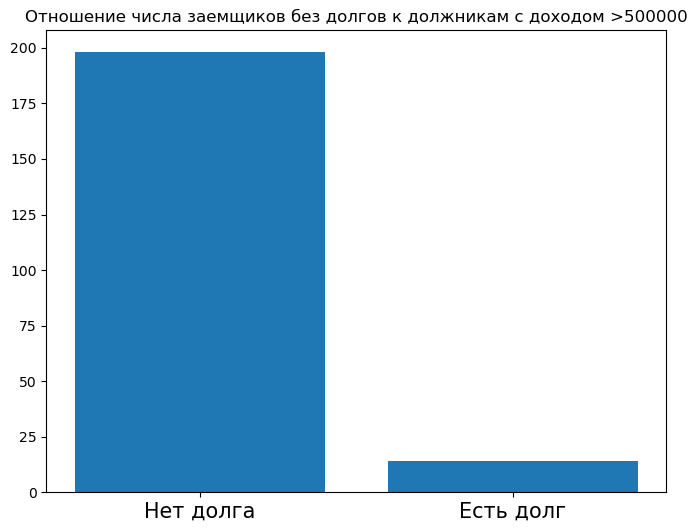

In [45]:
# распределение должников с доходом свыше 500000
fig, ax = plt.subplots(figsize=(8, 6))
rich_debt = df.query('total_income > 500000').groupby('debt')['total_income'].agg('count')

ax.bar(rich_debt.index, rich_debt.values)
x_labels = ['Нет долга','Есть долг']
ax.set_xticks(rich_debt.index)
ax.set_xticklabels(x_labels,fontsize=15)
ax.set(title='Отношение числа заемщиков без долгов к должникам с доходом >500000');

Преимущественно должники среди заёмщиков с окладом выше 500 тысяч отсутствуют, поэтому мы уберем эти выбросы, ограничившись 500 тыс.

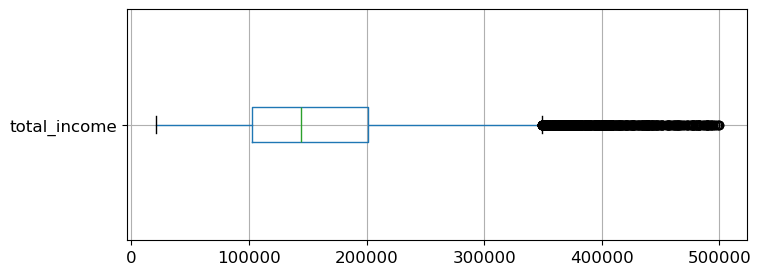

In [46]:
df = df.query('total_income <= 500000')
boxplot_col(df, 'total_income')

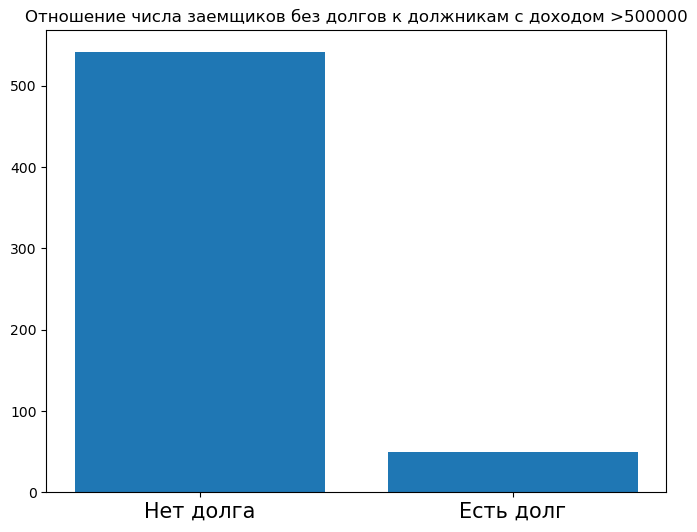

In [47]:
# распределение должников с доходом свыше 300000 и до 350000 вкл
fig, ax = plt.subplots(figsize=(8, 6))
rich_debt = df.query('total_income > 300000 & total_income <= 350000').groupby('debt')['total_income'].agg('count')

ax.bar(rich_debt.index, rich_debt.values)
x_labels = ['Нет долга','Есть долг']
ax.set_xticks(rich_debt.index)
ax.set_xticklabels(x_labels,fontsize=15)
ax.set(title='Отношение числа заемщиков без долгов к должникам с доходом >500000');

Мы видим, что и тут ситуация примерно схожая, поэтому обрежем хвост до 4 квантиля.

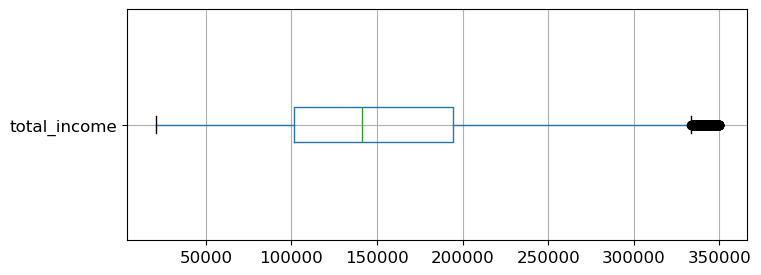

In [48]:
df = df.query('total_income <= 350000')
boxplot_col(df, 'total_income')

### purpose ###

In [49]:
col_info(df, 'purpose')

<bound method Series.info of 1             приобретение автомобиля
2                       покупка жилья
3          дополнительное образование
4                     сыграть свадьбу
5                       покупка жилья
                     ...             
21520               операции с жильем
21521            сделка с автомобилем
21522                    недвижимость
21523    на покупку своего автомобиля
21524           на покупку автомобиля
Name: purpose, Length: 17575, dtype: object>

Пропущенных значений: 0


purpose
свадьба                                   663
сыграть свадьбу                           624
на проведение свадьбы                     616
операции с недвижимостью                  566
покупка жилья                             539
покупка коммерческой недвижимости         538
покупка жилья для сдачи                   537
жилье                                     530
строительство жилой недвижимости          528
покупка жилья для семьи                   527
операции с жильем                         524
строительство недвижимости                521
недвижимость                              518
операции с коммерческой недвижимостью     517
покупка своего жилья                      511
операции со своей недвижимостью           508
строительство собственной недвижимости    506
покупка жилой недвижимости                496
ремонт жилью                              496
покупка недвижимости                      490
на покупку своего автомобиля              417
автомобиль                

In [50]:
# стандартизируем цели займа под четыре категории
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [51]:
df['purpose'] = df['purpose'].apply(categorize_purpose)

In [52]:
col_info(df, 'purpose')

<bound method Series.info of 1          операции с автомобилем
2        операции с недвижимостью
3           получение образования
4              проведение свадьбы
5        операции с недвижимостью
                   ...           
21520    операции с недвижимостью
21521      операции с автомобилем
21522    операции с недвижимостью
21523      операции с автомобилем
21524      операции с автомобилем
Name: purpose, Length: 17575, dtype: object>

Пропущенных значений: 0


purpose
операции с недвижимостью    8852
операции с автомобилем      3535
получение образования       3285
проведение свадьбы          1903
Name: count, dtype: int64

### Вывод по EDA ###

В ходе предобработки нам удалось избавиться от ошибок в данных, убрать выбросы, конкретизировать категории

## Исслед. анализ ##

Перед нами стоит две гипотезы, которые нам необходимо проверить:

1. количество детей клиента не влияет на погашение кредита в срок;
2. семейное положение не влияет на погашение кредита в срок.


### влияние детей ###

In [53]:
# функция агрегации должников и надежных клиентов с выводом графиков
def col_debt_stat(data, col, title_1, title_2, col_debt = 'debt'):
    debt_stat= pd.DataFrame({'total': data.groupby(col)[col_debt].agg('count'),
                             'debt': data.groupby(col)[col_debt].agg('sum'),
                             'percent': (data.groupby(col)[col_debt].
                                         agg(lambda x: (x.sum() / x.count()) * 100).round(2)
                                        )
                            })
    
    display(debt_stat) # отображение полученной таблицы
    print('='*120)
    # график сравнения должников и надежных клиентов
    fig, ax = plt.subplots(figsize=(8, 4)) 
    plt.plot(debt_stat['total'])
    plt.plot(debt_stat['debt'], color = 'red')
    plt.grid(True)
    plt.xticks(rotation = 45)
    plt.title(title_1)
    
    # график задолженности в процентах от общего числа клиентов
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(debt_stat['percent'].index, debt_stat['percent'][0:], color='#6B9C8E')
    plt.grid(True)
    plt.xticks(rotation = 45)
    plt.title(title_2)
    plt.show;

,total,debt,percent
children,,,
0,11562,891,7.71
1,4028,389,9.66
2,1711,166,9.70
3,274,21,7.66


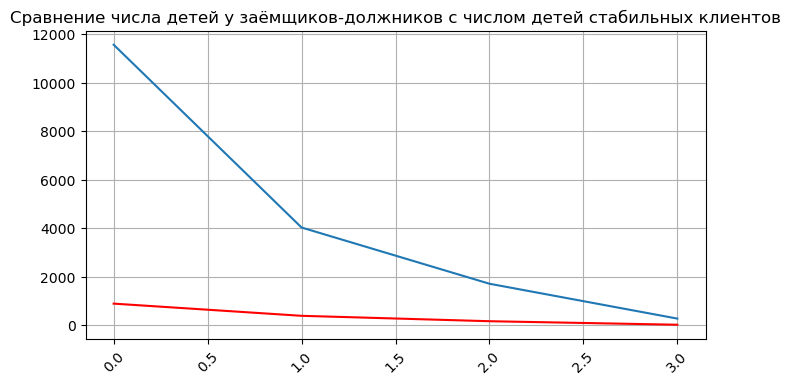

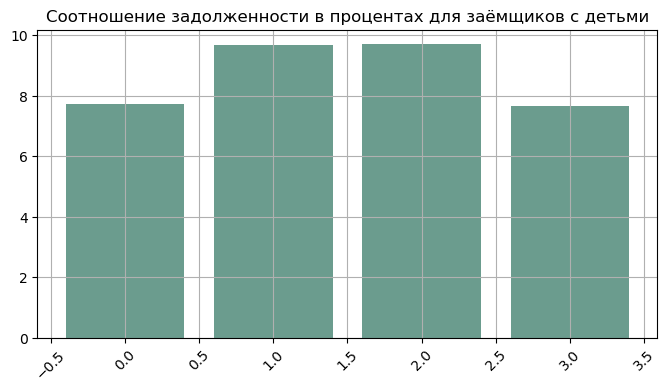

In [54]:
col_debt_stat(df, 
              'children', 
              'Сравнение числа детей у заёмщиков-должников c числом детей стабильных клиентов',
              'Соотношение задолженности в процентах для заёмщиков с детьми')

На графике наглядно видно, что статистика задолженности увеличивается для заёмщиков с одним и двумя детьми. Таким образом, мы можем сделать вывод, что **число детей заёмщика влияет на возврат и возникновение задолженности**. Усредним показатели для наглядности.

In [55]:
# выведем общий график, где True - отсутствие детей
df.groupby(df['children'] == 0).agg(всего_клиентов=('debt','count'),
                                    должников=('debt','sum'),
                                    доля_должников=('debt','mean')) \
                                   .style.format({'доля_должников' : '{:.2%}'})

,всего_клиентов,должников,доля_должников
children,,,
False,6013,576,9.58%
True,11562,891,7.71%


Сформулируем нулевую и первую гипотезы для нашего исследования:
* H0: количество детей заёмщика не влияет на возвращение кредита в срок

$$H_0: {mu} = {mu_0}$$

* H1: количество детей заёмщика влияет на возвращение кредита в срок

$$H_1: {mu} > {mu_0}$$

In [56]:
# клиенты без задолженности
#child_no_debt = random.sample(sorted(df['children'][(df['children'] >= 1) & (df['debt'] == 0)]), 500) 
child_no_debt = df['children'][(df['children'] >= 1) & (df['debt'] == 0)]

# клиенты с задолженностью
#child_debt = random.sample(sorted(df['children'][(df['children'] >= 1) & (df['debt'] == 1)]), 500) 
child_debt = df['children'][(df['children'] >= 1) & (df['debt'] == 1)]

pd.DataFrame({'Матожидание': [pd.Series(child_no_debt).mean(), pd.Series(child_debt).mean()],
              'Дисперсия': [np.var(child_no_debt), np.var(child_debt)]
             }, 
             index = ['no_debt', 'debt'])


,Матожидание,Дисперсия
no_debt,1.377230,0.327994
debt,1.361111,0.303627


In [57]:
# проведем статтест
def stat_test(x, y):
    alpha = .05 # уровень стат.значимости
    
    if len(x) != len(y):
        results = st.ttest_ind(x, y, random_state=69, equal_var=False)
    else:
        results = st.ttest_ind(x, y, random_state=69)
    
    print('p-значение:', results.pvalue)
    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу") 

In [58]:
stat_test(child_no_debt, child_debt)

p-значение: 0.5065731660581204
Не получилось отвергнуть нулевую гипотезу


Таким образом, мы подтверждаем, что наша нулевая гипотеза **верна** и делаем вывод, что количество детей ***не влияет*** на возникновение задолженности

### семейное положение ###

,total,debt,percent
family_status,,,
в разводе,976,70,7.17
вдовец / вдова,805,54,6.71
гражданский брак,3410,315,9.24
женат / замужем,10066,791,7.86
не женат / не замужем,2318,237,10.22


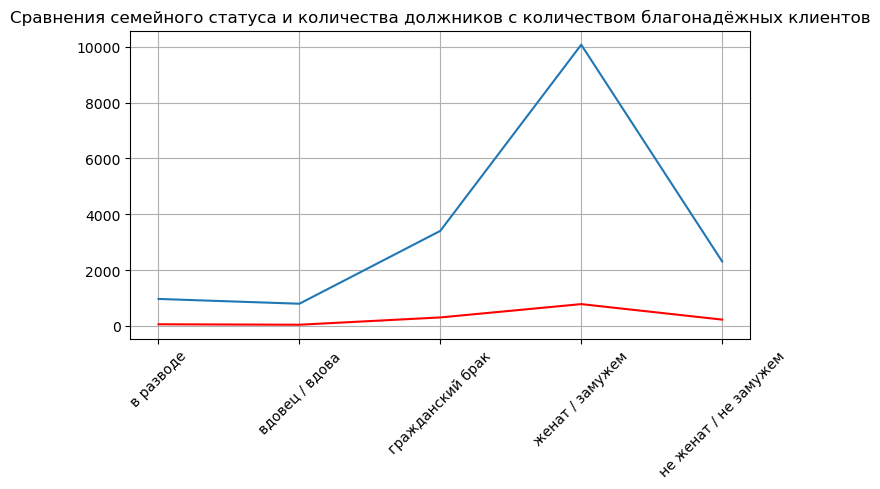

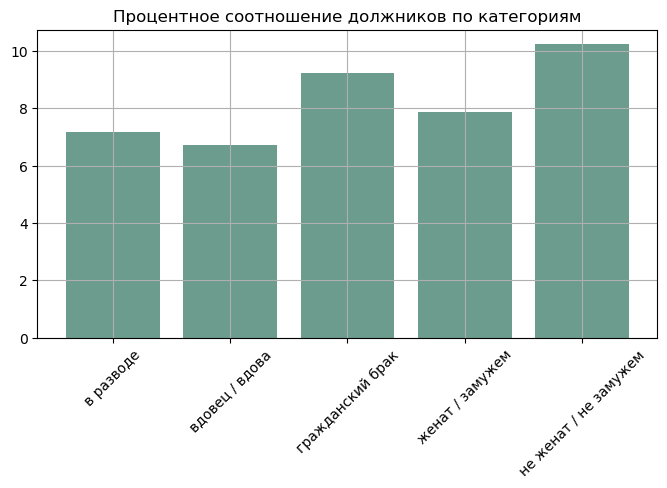

In [59]:
col_debt_stat(df, 
              'family_status', 
              'Сравнения семейного статуса и количества должников с количеством благонадёжных клиентов',
              'Процентное соотношение должников по категориям')

Исходя из полученных данных мы видим, что наибольшее число должников находится в группе **не женат / не замужем**. В данном случае мы имеем наглядную картинку опровергающую нашу гипотезу о том, что **семейное положение не влияет на возникновение задолженности**.

В данном случае одной из ключевых причин подобного распределения является образ жизни представителя категории, который не несёт ответственности ни за кого, кроме себя. Преобладающее число же замужниъ/женатых клиентов находятся лишь на третьем из пяти мест: эти люди не только несут ответственность за себя и другого человека, но и могут кооперировать финансы, распределять их по нуждам и планировать расходы на основании двух бюджетов одной семьи.

## Подготовка данных к моделированию ##

In [60]:
df.head()

,children,years_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
1,1,11,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,операции с автомобилем
2,0,15,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,операции с недвижимостью
3,3,11,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,получение образования
4,0,0,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,проведение свадьбы
5,0,2,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,операции с недвижимостью


In [61]:
# удалим некодированные столбцы
try:
    df = df.drop(['family_status', 'education'], axis=1)
except:
    pass

In [62]:
df.head()

,children,years_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose
1,1,11,36,1,0,F,сотрудник,0,112080.014102,операции с автомобилем
2,0,15,33,1,0,M,сотрудник,0,145885.952297,операции с недвижимостью
3,3,11,32,1,0,M,сотрудник,0,267628.550329,получение образования
4,0,0,53,1,1,F,пенсионер,0,158616.077870,проведение свадьбы
5,0,2,27,0,1,M,компаньон,0,255763.565419,операции с недвижимостью


In [63]:
STATE = 69

features = df.drop('debt', axis=1)
target = df['debt']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.3, random_state=STATE, shuffle=True)

In [64]:
pd.DataFrame({'train': [X_train.shape, y_train.shape],
              'test': [X_test.shape, y_test.shape]
             })

,train,test
0,"(12302, 9)","(5273, 9)"
1,"(12302,)","(5273,)"


### Кодирование ###

In [65]:
X_train_le = X_train.copy()
X_test_le = X_test.copy()

cat_cols = []
for i in X_train.columns:
    if X_train[i].dtype == 'O':
        cat_cols.append(i)

# функция трансформации сэмплов
def encoding(data):
    for i in data[cat_cols]:
        le = LabelEncoder().fit(X_train[i]) 
        data[i] = le.transform(data[i])
    return data

# кодируем сэмплы
X_train_le = encoding(X_train_le)
X_test_le = encoding(X_test_le)


In [66]:
X_train_le

,children,years_employed,dob_years,education_id,family_status_id,gender,income_type,total_income,purpose
20405,1,8,30,1,0,1,3,139455.744875,1
17822,0,0,58,1,0,1,2,214802.165118,1
16782,0,10,38,1,1,1,1,137399.141505,1
16,0,4,35,1,0,0,3,289202.704229,1
3205,0,1,42,1,1,0,3,99930.424599,3
...,...,...,...,...,...,...,...,...,...
5328,2,4,31,0,1,0,3,58761.068641,3
14410,0,2,41,1,1,0,3,102483.846674,3
17998,3,7,41,0,0,1,3,247441.677157,0
11993,0,1,62,1,2,0,2,84090.384090,2


### Корреляция ###

interval columns not set, guessing: ['children', 'years_employed', 'dob_years', 'education_id', 'family_status_id', 'gender', 'income_type', 'total_income', 'purpose']


C:\Users\Home\AppData\Roaming\Python\Python39\site-packages\phik\phik.py:150: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_binned.replace(defs.UF, np.nan, inplace=True)


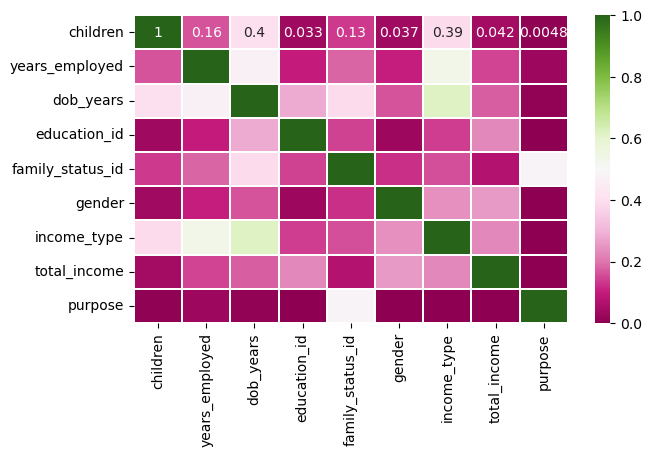

In [67]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.heatmap(X_train_le.phik_matrix(), annot=True, linewidth=0.2, cmap="PiYG")
plt.show;

## Моделирование ##